# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [ ]:
# Для работы в колабе раскоменьте эти строки
!git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
%cd DeepGenerativeModels/

%load_ext autoreload
%autoreload 2

Cloning into 'DeepGenerativeModels'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 656 (delta 85), reused 161 (delta 56), pack-reused 447
Receiving objects: 100% (656/656), 179.42 MiB | 41.14 MiB/s, done.
Resolving deltas: 100% (265/265), done.
/content/DeepGenerativeModels/DeepGenerativeModels
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#download_url = 'https://drive.google.com/uc?id=18iuZMt37xcsXPuQfBzepW90JP95HkkRY'

In [ ]:
#!g1.1
import sys
sys.path.append('/content/DeepGenerativeModels/utils/datasets/')
from utils.datasets.celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.auto import trange, tqdm
import os 
from torch import nn

from torch import Tensor

import torch.distributions as distributions
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

In [ ]:
#!g1.1
t_normalize = lambda x: x * 2 - 1
t_invnormalize = lambda x: (x + 1) / 2
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    #transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor(),
    #t_normalize,
])

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
root_dir = '/content/DeepGenerativeModels/data/celeba'
if not os.path.isdir(root_dir):
    os.makedirs(root_dir)

import gdown, os
gdown.download("https://drive.google.com/uc?id=1JzOrzDS3bMbFArIy2bRXzoPGD4hrGdVh", 
               './data/celeba/list_attr_celeba.txt', 
               quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1JzOrzDS3bMbFArIy2bRXzoPGD4hrGdVh
To: /content/DeepGenerativeModels/data/celeba/list_attr_celeba.txt
100%|██████████| 26.5M/26.5M [00:00<00:00, 180MB/s]


'./data/celeba/list_attr_celeba.txt'

In [ ]:
#!g1.1
from random import randint

class CelebaCustomDataset(CelebADataset):
    def __getitem__(self, idx):
        image, target = super().__getitem__(idx)
        return image

dataset = CelebaCustomDataset(
    transform=transform,
    #attr_file_path='list_attr_celeba.txt',
    #crop=False
)

img = dataset[0]
img.shape

torch.Size([3, 64, 64])

### Визуализация датасета

In [ ]:
#!g1.1
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

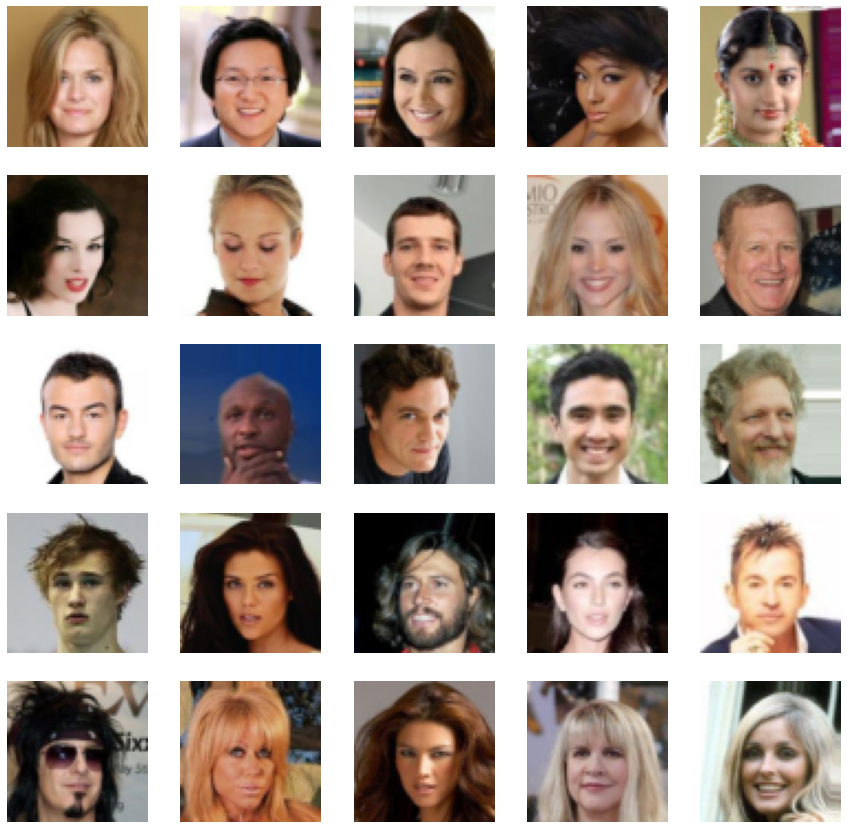

In [ ]:
#!g1.1
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=64,
                                         shuffle=True,
                                         drop_last=True)

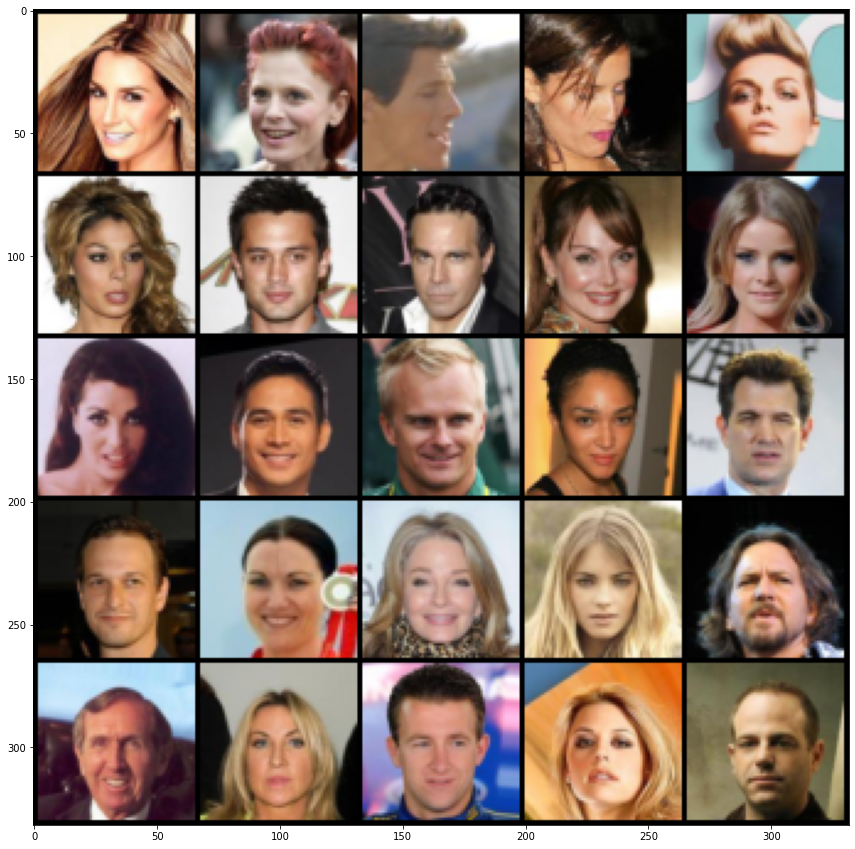

In [ ]:
from torchvision.utils import make_grid
plt.figure(figsize=(15,15))
plt.imshow(make_grid([dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Используем здесь в качестве норм потока - real NVP

In [ ]:
class WeightNormConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0, 
        bias=True, weight_norm=True, scale=False):
        """Intializes a Conv2d augmented with weight normalization.
        (See torch.nn.utils.weight_norm for detail.)
        Args:
            in_dim: number of input channels.
            out_dim: number of output channels.
            kernel_size: size of convolving kernel.
            stride: stride of convolution.
            padding: zero-padding added to both sides of input.
            bias: True if include learnable bias parameters, False otherwise.
            weight_norm: True if apply weight normalization, False otherwise.
            scale: True if include magnitude parameters, False otherwise.
        """
        super(WeightNormConv2d, self).__init__()

        #if weight_norm:
        self.conv = nn.utils.weight_norm(
            nn.Conv2d(in_dim, out_dim, kernel_size, 
                stride=stride, padding=padding, bias=bias))
        if not scale:
            self.conv.weight_g.data = torch.ones_like(self.conv.weight_g.data)
            self.conv.weight_g.requires_grad = False    # freeze scaling

    def forward(self, x):
        """Forward pass.
        Args:
            x: input tensor.
        Returns:
            transformed tensor.
        """
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim, bottleneck, weight_norm):
        """Initializes a ResidualBlock.
        Args:
            dim: number of input and output features.
            bottleneck: True if use bottleneck, False otherwise.
            weight_norm: True if apply weight normalization, False otherwise.
        """
        super(ResidualBlock, self).__init__()
        
        self.in_block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU())
        if bottleneck:
            self.res_block = nn.Sequential(
                WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0, 
                    bias=False, weight_norm=weight_norm, scale=False),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1, 
                    bias=False, weight_norm=weight_norm, scale=False),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0, 
                    bias=True, weight_norm=weight_norm, scale=True))
        else:
            self.res_block = nn.Sequential(
                WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1, 
                    bias=False, weight_norm=weight_norm, scale=False),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1, 
                    bias=True, weight_norm=weight_norm, scale=True))

    def forward(self, x):
        """Forward pass.
        Args:
            x: input tensor.
        Returns:
            transformed tensor.
        """
        return x + self.res_block(self.in_block(x))

class ResidualModule(nn.Module):
    def __init__(self, in_dim, dim, out_dim, 
        res_blocks, bottleneck, skip, weight_norm):
        """Initializes a ResidualModule.
        Args:
            in_dim: number of input features.
            dim: number of features in residual blocks.
            out_dim: number of output features.
            res_blocks: number of residual blocks to use.
            bottleneck: True if use bottleneck, False otherwise.
            skip: True if use skip architecture, False otherwise.
            weight_norm: True if apply weight normalization, False otherwise.
        """
        super(ResidualModule, self).__init__()
        self.res_blocks = res_blocks
        self.skip = skip
        
        if res_blocks > 0:
            self.in_block = WeightNormConv2d(in_dim, dim, (3, 3), stride=1, 
                padding=1, bias=True, weight_norm=weight_norm, scale=False)
            self.core_block = nn.ModuleList(
                [ResidualBlock(dim, bottleneck, weight_norm) 
                for _ in range(res_blocks)])
            self.out_block = nn.Sequential(
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                WeightNormConv2d(dim, out_dim, (1, 1), stride=1, padding=0, 
                    bias=True, weight_norm=weight_norm, scale=True))
        
            if skip:
                self.in_skip = WeightNormConv2d(dim, dim, (1, 1), stride=1, 
                    padding=0, bias=True, weight_norm=weight_norm, scale=True)
                self.core_skips = nn.ModuleList(
                    [WeightNormConv2d(
                        dim, dim, (1, 1), stride=1, padding=0, bias=True, 
                        weight_norm=weight_norm, scale=True) 
                    for _ in range(res_blocks)])
        else:
            self.block = nn.Sequential(
                WeightNormConv2d(in_dim, dim, (3, 3), stride=1, padding=1, 
                    bias=False, weight_norm=weight_norm, scale=False),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                WeightNormConv2d(dim, out_dim, (3, 3), stride=1, padding=1, 
                    bias=True, weight_norm=weight_norm, scale=True))

    def forward(self, x):
        """Forward pass.
        Args:
            x: input tensor.
        Returns:
            transformed tensor.
        """
        if self.res_blocks > 0:
            x = self.in_block(x)
            if self.skip:
                out = self.in_skip(x)
            for i in range(len(self.core_block)):
                x = self.core_block[i](x)
                if self.skip:
                    out = out + self.core_skips[i](x)
            if self.skip:
                x = out
            return self.out_block(x)
        else:
            return self.block(x)

class AbstractCoupling(nn.Module):
    def __init__(self, mask_config, hps):
        """Initializes an AbstractCoupling.
        Args:
            mask_config: mask configuration (see build_mask() for more detail).
            hps: the set of hyperparameters.
        """
        super(AbstractCoupling, self).__init__()
        self.mask_config = mask_config
        self.res_blocks = hps.res_blocks
        self.bottleneck = hps.bottleneck
        self.skip = hps.skip
        self.weight_norm = hps.weight_norm
        self.coupling_bn = hps.coupling_bn

    def build_mask(self, size, config=1.):
        """Builds a binary checkerboard mask.
        (Only for constructing masks for checkerboard coupling layers.)
        Args:
            size: height/width of features.
            config: mask configuration that determines which pixels to mask up.
                    if 1:        if 0:
                        1 0         0 1
                        0 1         1 0
        Returns:
            a binary mask (1: pixel on, 0: pixel off).
        """
        mask = np.arange(size).reshape(-1, 1) + np.arange(size)
        mask = np.mod(config + mask, 2)
        mask = mask.reshape(-1, 1, size, size)
        return torch.tensor(mask.astype('float32'))

    def batch_stat(self, x):
        """Compute (spatial) batch statistics.
        Args:
            x: input minibatch.
        Returns:
            batch mean and variance.
        """
        mean = torch.mean(x, dim=(0, 2, 3), keepdim=True)
        var = torch.mean((x - mean)**2, dim=(0, 2, 3), keepdim=True)
        return mean, var


class CheckerboardAffineCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, size, mask_config, hps):
        """Initializes a CheckerboardAffineCoupling.
        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            size: height/width of features.
            mask_config: mask configuration (see build_mask() for more detail).
            hps: the set of hyperparameters.
        """
        super(CheckerboardAffineCoupling, self).__init__(mask_config, hps)

        self.mask = self.build_mask(size, config=mask_config).cuda()              ##########################. !!!!!!!!!!!!!!!!!!
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.in_bn = nn.BatchNorm2d(in_out_dim)
        self.block = nn.Sequential(        # 1st half of resnet: shift
            nn.ReLU(),                    # 2nd half of resnet: log_rescale
            ResidualModule(2*in_out_dim+1, mid_dim, 2*in_out_dim, 
                self.res_blocks, self.bottleneck, self.skip, self.weight_norm))
        self.out_bn = nn.BatchNorm2d(in_out_dim, affine=False)

    def forward(self, x, reverse=False):
        """Forward pass.
        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        [B, C, _, _] = list(x.size())
        mask = self.mask.repeat(B, 1, 1, 1)
        x_ = self.in_bn(x * mask)
        x_ = torch.cat((x_, -x_), dim=1)
        x_ = torch.cat((x_, mask), dim=1)    # 2C+1 channels
        (shift, log_rescale) = self.block(x_).split(C, dim=1)
        log_rescale = self.scale * torch.tanh(log_rescale) + self.scale_shift
        shift = shift * (1. - mask)
        log_rescale = log_rescale * (1. - mask)
        
        log_diag_J = log_rescale     # See Eq(6) in real NVP 
        # See Eq(7) and Eq(8) and Section 3.7 in real NVP
        if reverse:
            if self.coupling_bn:
                mean, var = self.out_bn.running_mean, self.out_bn.running_var
                mean = mean.reshape(-1, 1, 1, 1).transpose(0, 1)
                var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                x = x * torch.exp(0.5 * torch.log(var + 1e-5) * (1. - mask)) \
                    + mean * (1. - mask)
            x = (x - shift) * torch.exp(-log_rescale)
        else:
            x = x * torch.exp(log_rescale) + shift
            if self.coupling_bn:
                if self.training:
                    _, var = self.batch_stat(x)
                else:
                    var = self.out_bn.running_var
                    var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                x = self.out_bn(x) * (1. - mask) + x * mask
                log_diag_J = log_diag_J - 0.5 * torch.log(var + 1e-5) * (1. - mask)
        return x, log_diag_J

class CheckerboardCoupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, size, mask_config, hps):
        """Initializes a CheckerboardCoupling.
        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            size: height/width of features.
            mask_config: mask configuration (see build_mask() for more detail).
            hps: the set of hyperparameters.
        """
        super(CheckerboardCoupling, self).__init__()

        if hps.affine:
            self.coupling = CheckerboardAffineCoupling(
                in_out_dim, mid_dim, size, mask_config, hps)

    def forward(self, x, reverse=False):
        """Forward pass.
        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        return self.coupling(x, reverse)


class ChannelwiseAffineCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, mask_config, hps):
        """Initializes a ChannelwiseAffineCoupling.
        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            mask_config: 1 if change the top half, 0 if change the bottom half.
            hps: the set of hyperparameters.
        """
        super(ChannelwiseAffineCoupling, self).__init__(mask_config, hps)

        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.in_bn = nn.BatchNorm2d(in_out_dim//2)
        self.block = nn.Sequential(        # 1st half of resnet: shift
            nn.ReLU(),                    # 2nd half of resnet: log_rescale
            ResidualModule(in_out_dim, mid_dim, in_out_dim, 
                self.res_blocks, self.bottleneck, self.skip, self.weight_norm))
        self.out_bn = nn.BatchNorm2d(in_out_dim//2, affine=False)

    def forward(self, x, reverse=False):
        """Forward pass.
        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        [_, C, _, _] = list(x.size())
        if self.mask_config:
            (on, off) = x.split(C//2, dim=1)
        else:
            (off, on) = x.split(C//2, dim=1)
        off_ = self.in_bn(off)
        off_ = torch.cat((off_, -off_), dim=1)     # C channels
        out = self.block(off_)
        (shift, log_rescale) = out.split(C//2, dim=1)
        log_rescale = self.scale * torch.tanh(log_rescale) + self.scale_shift
        
        log_diag_J = log_rescale     # See Eq(6) in real NVP
        # See Eq(7) and Eq(8) and Section 3.7 in real NVP
        if reverse:
            if self.coupling_bn:
                mean, var = self.out_bn.running_mean, self.out_bn.running_var
                mean = mean.reshape(-1, 1, 1, 1).transpose(0, 1)
                var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                on = on * torch.exp(0.5 * torch.log(var + 1e-5)) + mean
            on = (on - shift) * torch.exp(-log_rescale)
        else:
            on = on * torch.exp(log_rescale) + shift
            if self.coupling_bn:
                if self.training:
                    _, var = self.batch_stat(on)
                else:
                    var = self.out_bn.running_var
                    var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                on = self.out_bn(on)
                log_diag_J = log_diag_J - 0.5 * torch.log(var + 1e-5)
        if self.mask_config:
            x = torch.cat((on, off), dim=1)
            log_diag_J = torch.cat((log_diag_J, torch.zeros_like(log_diag_J)), 
                dim=1)
        else:
            x = torch.cat((off, on), dim=1)
            log_diag_J = torch.cat((torch.zeros_like(log_diag_J), log_diag_J), 
                dim=1)
        return x, log_diag_J

class ChannelwiseCoupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, mask_config, hps):
        """Initializes a ChannelwiseCoupling.
        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            mask_config: 1 if change the top half, 0 if change the bottom half.
            hps: the set of hyperparameters.
        """
        super(ChannelwiseCoupling, self).__init__()

        if hps.affine:
            self.coupling = ChannelwiseAffineCoupling(
                in_out_dim, mid_dim, mask_config, hps)

    def forward(self, x, reverse=False):
        """Forward pass.
        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        return self.coupling(x, reverse)

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, datainfo, prior, hps):
        """Initializes a RealNVP.
        Args:
            datainfo: information of dataset to be modeled.
            prior: prior distribution over latent space Z.
            hps: the set of hyperparameters.
        """
        super(RealNVP, self).__init__()
        self.datainfo = datainfo
        self.prior = prior
        self.hps = hps

        chan = datainfo.channel
        size = datainfo.size
        dim = hps.base_dim

        # 
        # SCALE 1: 
        self.s1_ckbd = self.checkerboard_combo(chan, dim, size, hps)
        self.s1_chan = self.channelwise_combo(chan*4, dim*2, hps)
        self.order_matrix_1 = self.order_matrix(chan).cuda()
        chan *= 2
        size //= 2
        dim *= 2

        # SCALE 2: 
        self.s2_ckbd = self.checkerboard_combo(chan, dim, size, hps)
        self.s2_chan = self.channelwise_combo(chan*4, dim*2, hps)
        self.order_matrix_2 = self.order_matrix(chan).cuda()
        chan *= 2
        size //= 2
        dim *= 2

        # SCALE 3: 
        self.s3_ckbd = self.checkerboard_combo(chan, dim, size, hps)
        self.s3_chan = self.channelwise_combo(chan*4, dim*2, hps)
        self.order_matrix_3 = self.order_matrix(chan).cuda()
        chan *= 2
        size //= 2
        dim *= 2

        # SCALE 4: 
        self.s4_ckbd = self.checkerboard_combo(chan, dim, size, hps)
        self.s4_chan = self.channelwise_combo(chan*4, dim*2, hps)
        self.order_matrix_4 = self.order_matrix(chan).cuda()
        chan *= 2
        size //= 2
        dim *= 2

        # SCALE 5: 
        self.s5_ckbd = self.checkerboard_combo(chan, dim, size, hps, final=True)

    def checkerboard_combo(self, in_out_dim, mid_dim, size, hps, final=False):
        """Construct a combination of checkerboard coupling layers.
        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            size: height/width of features.
            hps: the set of hyperparameters.
            final: True if at final scale, False otherwise.
        Returns:
            A combination of checkerboard coupling layers.
        """
        if final:
            return nn.ModuleList([
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0., hps)])
        else:
            return nn.ModuleList([
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps), 
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps)])
        
    def channelwise_combo(self, in_out_dim, mid_dim, hps):
        """Construct a combination of channelwise coupling layers.
        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            hps: the set of hyperparameters.
        Returns:
            A combination of channelwise coupling layers.
        """
        return nn.ModuleList([
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps)])

    def squeeze(self, x):
        """Squeezes a C x H x W tensor into a 4C x H/2 x W/2 tensor.
        (See Fig 3 in the real NVP paper.)
        Args:
            x: input tensor (B x C x H x W).
        Returns:
            the squeezed tensor (B x 4C x H/2 x W/2).
        """
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H//2, 2, W//2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C*4, H//2, W//2)
        return x

    def undo_squeeze(self, x):
        """unsqueezes a C x H x W tensor into a C/4 x 2H x 2W tensor.
        (See Fig 3 in the real NVP paper.)
        Args:
            x: input tensor (B x C x H x W).
        Returns:
            the squeezed tensor (B x C/4 x 2H x 2W).
        """
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C//4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C//4, H*2, W*2)
        return x

    def order_matrix(self, channel):
        """Constructs a matrix that defines the ordering of variables
        when downscaling/upscaling is performed.
        Args:
          channel: number of features.
        Returns:
          a kernel for rearrange the variables.
        """
        weights = np.zeros((channel*4, channel, 2, 2))
        ordering = np.array([[[[1., 0.],
                               [0., 0.]]],
                             [[[0., 0.],
                               [0., 1.]]],
                             [[[0., 1.],
                               [0., 0.]]],
                             [[[0., 0.],
                               [1., 0.]]]])
        for i in range(channel):
            s1 = slice(i, i+1)
            s2 = slice(4*i, 4*(i+1))
            weights[s2, s1, :, :] = ordering
        shuffle = np.array([4*i for i in range(channel)]
                         + [4*i+1 for i in range(channel)]
                         + [4*i+2 for i in range(channel)]
                         + [4*i+3 for i in range(channel)])
        weights = weights[shuffle, :, :, :].astype('float32')
        return torch.tensor(weights)

    def factor_out(self, x, order_matrix):
        """Downscales and factors out the bottom half of the tensor.
        (See Fig 4(b) in the real NVP paper.)
        Args:
            x: input tensor (B x C x H x W).
            order_matrix: a kernel that defines the ordering of variables.
        Returns:
            the top half for further transformation (B x 2C x H/2 x W/2)
            and the Gaussianized bottom half (B x 2C x H/2 x W/2).
        """
        x = F.conv2d(x, order_matrix, stride=2, padding=0)
        [_, C, _, _] = list(x.size())
        (on, off) = x.split(C//2, dim=1)
        return on, off

    def restore(self, on, off, order_matrix):
        """Merges variables and restores their ordering.
        (See Fig 4(b) in the real NVP paper.)
        Args:
            on: the active (transformed) variables (B x C x H x W).
            off: the inactive variables (B x C x H x W).
            order_matrix: a kernel that defines the ordering of variables.
        Returns:
            combined variables (B x 2C x H x W).
        """
        x = torch.cat((on, off), dim=1)
        return F.conv_transpose2d(x, order_matrix, stride=2, padding=0)

    def g(self, z):
        """Transformation g: Z -> X (inverse of f).
        Args:
            z: tensor in latent space Z.
        Returns:
            transformed tensor in data space X.
        """
        x, x_off_1 = self.factor_out(z, self.order_matrix_1)

        if self.datainfo.name in ['imnet32', 'imnet64', 'celeba']:
            x, x_off_2 = self.factor_out(x, self.order_matrix_2)
            x, x_off_3 = self.factor_out(x, self.order_matrix_3)

            x, x_off_4 = self.factor_out(x, self.order_matrix_4)

            # SCALE 5: 
            for i in reversed(range(len(self.s5_ckbd))):
                x, _ = self.s5_ckbd[i](x, reverse=True)
            
            x = self.restore(x, x_off_4, self.order_matrix_4)

            # SCALE 4: 
            x = self.squeeze(x)
            for i in reversed(range(len(self.s4_chan))):
                x, _ = self.s4_chan[i](x, reverse=True)
            x = self.undo_squeeze(x)

            for i in reversed(range(len(self.s4_ckbd))):
                x, _ = self.s4_ckbd[i](x, reverse=True)

            x = self.restore(x, x_off_3, self.order_matrix_3)

            # SCALE 3: 
            x = self.squeeze(x)
            for i in reversed(range(len(self.s3_chan))):
                x, _ = self.s3_chan[i](x, reverse=True)
            x = self.undo_squeeze(x)

            for i in reversed(range(len(self.s3_ckbd))):
                x, _ = self.s3_ckbd[i](x, reverse=True)

            x = self.restore(x, x_off_2, self.order_matrix_2)

            # SCALE 2: 
            x = self.squeeze(x)
            for i in reversed(range(len(self.s2_chan))):
                x, _ = self.s2_chan[i](x, reverse=True)
            x = self.undo_squeeze(x)

        for i in reversed(range(len(self.s2_ckbd))):
            x, _ = self.s2_ckbd[i](x, reverse=True)

        x = self.restore(x, x_off_1, self.order_matrix_1)

        # SCALE 1: 
        x = self.squeeze(x)
        for i in reversed(range(len(self.s1_chan))):
            x, _ = self.s1_chan[i](x, reverse=True)
        x = self.undo_squeeze(x)

        for i in reversed(range(len(self.s1_ckbd))):
            x, _ = self.s1_ckbd[i](x, reverse=True)

        return x

    def f(self, x):
        """Transformation f: X -> Z (inverse of g).
        Args:
            x: tensor in data space X.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        z, log_diag_J = x, torch.zeros_like(x)

        # SCALE 1: 
        for i in range(len(self.s1_ckbd)):
            z, inc = self.s1_ckbd[i](z)
            log_diag_J = log_diag_J + inc

        z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)
        for i in range(len(self.s1_chan)):
            z, inc = self.s1_chan[i](z)
            log_diag_J = log_diag_J + inc
        z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

        z, z_off_1 = self.factor_out(z, self.order_matrix_1)
        log_diag_J, log_diag_J_off_1 = self.factor_out(log_diag_J, self.order_matrix_1)

        # SCALE 2: 
        for i in range(len(self.s2_ckbd)):
            z, inc = self.s2_ckbd[i](z)
            log_diag_J = log_diag_J + inc

        if self.datainfo.name in ['imnet32', 'imnet64', 'celeba']:
            z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)
            for i in range(len(self.s2_chan)):
                z, inc = self.s2_chan[i](z)
                log_diag_J = log_diag_J + inc
            z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

            z, z_off_2 = self.factor_out(z, self.order_matrix_2)
            log_diag_J, log_diag_J_off_2 = self.factor_out(log_diag_J, self.order_matrix_2)

            # SCALE 3: 
            for i in range(len(self.s3_ckbd)):
                z, inc = self.s3_ckbd[i](z)
                log_diag_J = log_diag_J + inc

            z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)
            for i in range(len(self.s3_chan)):
                z, inc = self.s3_chan[i](z)
                log_diag_J = log_diag_J + inc
            z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

            z, z_off_3 = self.factor_out(z, self.order_matrix_3)
            log_diag_J, log_diag_J_off_3 = self.factor_out(log_diag_J, self.order_matrix_3)

            # SCALE 4: 
            for i in range(len(self.s4_ckbd)):
                z, inc = self.s4_ckbd[i](z)
                log_diag_J = log_diag_J + inc

            if self.datainfo.name in ['imnet64', 'celeba']:
                z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)
                for i in range(len(self.s4_chan)):
                    z, inc = self.s4_chan[i](z)
                    log_diag_J = log_diag_J + inc
                z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

                z, z_off_4 = self.factor_out(z, self.order_matrix_4)
                log_diag_J, log_diag_J_off_4 = self.factor_out(log_diag_J, self.order_matrix_4)

                # SCALE 5: 4 x 4
                for i in range(len(self.s5_ckbd)):
                    z, inc = self.s5_ckbd[i](z)
                    log_diag_J = log_diag_J + inc

                z = self.restore(z, z_off_4, self.order_matrix_4)
                log_diag_J = self.restore(log_diag_J, log_diag_J_off_4, self.order_matrix_4)

            z = self.restore(z, z_off_3, self.order_matrix_3)
            z = self.restore(z, z_off_2, self.order_matrix_2)
            log_diag_J = self.restore(log_diag_J, log_diag_J_off_3, self.order_matrix_3)
            log_diag_J = self.restore(log_diag_J, log_diag_J_off_2, self.order_matrix_2)
        
        z = self.restore(z, z_off_1, self.order_matrix_1)
        log_diag_J = self.restore(log_diag_J, log_diag_J_off_1, self.order_matrix_1)

        return z, log_diag_J

    def log_prob(self, x):
        """Computes data log-likelihood.
        (See Eq(2) and Eq(3) in the real NVP paper.)
        Args:
            x: input minibatch.
        Returns:
            log-likelihood of input.
        """
        z, log_diag_J = self.f(x)
        log_det_J = torch.sum(log_diag_J, dim=(1, 2, 3))
        log_prior_prob = torch.sum(self.prior.log_prob(z), dim=(1, 2, 3))
        return log_prior_prob + log_det_J

    def sample(self, size):
        """Generates samples.
        Args:
            size: number of samples to generate.
        Returns:
            samples from the data space X.
        """
        C = self.datainfo.channel
        H = W = self.datainfo.size
        z = self.prior.sample((size, C, H, W))
        return self.g(z)

    def forward(self, x):
        """Forward pass.
        Args:
            x: input minibatch.
        Returns:
            log-likelihood of input and sum of squares of scaling factors.
            (the latter is used in L2 regularization.)
        """
        weight_scale = None
        for name, param in self.named_parameters():
            param_name = name.split('.')[-1]
            if param_name in ['weight_g', 'scale'] and param.requires_grad:
                if weight_scale is None:
                    weight_scale = torch.pow(param, 2).sum()
                else:
                    weight_scale = weight_scale + torch.pow(param, 2).sum()
        return self.log_prob(x), weight_scale

In [ ]:
class DataInfo():
    def __init__(self, name, channel, size):
        """Instantiates a DataInfo.
        Args:
            name: name of dataset.
            channel: number of image channels.
            size: height and width of an image.
        """
        self.name = name
        self.channel = channel
        self.size = size

data_info = DataInfo('celeba', 3, 64)

batch_size = 64
base_dim = 32
res_blocks = 2
bottleneck = 0
skip = 1
weight_norm = 1
coupling_bn = 1
affine = 1

max_epoch =20000
sample_size = 64
lr = 1e-3
momentum = 0.9
decay = 0.999

In [ ]:
[train_split, val_split] = torch.utils.data.random_split(dataset, [189417, 13182])

train_loader = torch.utils.data.DataLoader(train_split,
          batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_split,
          batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

In [ ]:
len(train_loader.dataset), len(val_loader.dataset)

(189417, 13182)

In [ ]:
device

device(type='cpu')

In [ ]:
class Hyperparameters():
    def __init__(self, base_dim, res_blocks, bottleneck, 
        skip, weight_norm, coupling_bn, affine):
        """Instantiates a set of hyperparameters used for constructing layers.
        Args:
            base_dim: features in residual blocks of first few layers.
            res_blocks: number of residual blocks to use.
            bottleneck: True if use bottleneck, False otherwise.
            skip: True if use skip architecture, False otherwise.
            weight_norm: True if apply weight normalization, False otherwise.
            coupling_bn: True if batchnorm coupling layer output, False otherwise.
            affine: True if use affine coupling, False if use additive coupling.
        """
        self.base_dim = base_dim
        self.res_blocks = res_blocks
        self.bottleneck = bottleneck
        self.skip = skip
        self.weight_norm = weight_norm
        self.coupling_bn = coupling_bn
        self.affine = affine

hps = Hyperparameters(
    base_dim = base_dim, 
    res_blocks = res_blocks, 
    bottleneck = bottleneck, 
    skip = skip, 
    weight_norm = weight_norm, 
    coupling_bn = coupling_bn, 
    affine = affine)
scale_reg = 5e-5    # L2 regularization strength

# prefix for images and checkpoints
filename = 'bs%d_' % batch_size \
          + 'normal_' \
          + 'bd%d_' % hps.base_dim \
          + 'rb%d_' % hps.res_blocks \
          + 'bn%d_' % hps.bottleneck \
          + 'sk%d_' % hps.skip \
          + 'wn%d_' % hps.weight_norm \
          + 'cb%d_' % hps.coupling_bn \
          + 'af%d' % hps.affine 

In [ ]:
def logit_transform(x, constraint=0.9, reverse=False):
    '''Transforms data from [0, 1] into unbounded space.
    Restricts data into [0.05, 0.95].
    Calculates logit(alpha+(1-alpha)*x).
    Args:
        x: input tensor.
        constraint: data constraint before logit.
        reverse: True if transform data back to [0, 1].
    Returns:
        transformed tensor and log-determinant of Jacobian from the transform.
        (if reverse=True, no log-determinant is returned.)
    '''
    if reverse:
        x = 1. / (torch.exp(-x) + 1.)    # [0.05, 0.95]
        x *= 2.             # [0.1, 1.9]
        x -= 1.             # [-0.9, 0.9]
        x /= constraint     # [-1, 1]
        x += 1.             # [0, 2]
        x /= 2.             # [0, 1]
        return x, 0
    else:
        [B, C, H, W] = list(x.size())
        
        # dequantization
        noise = distributions.Uniform(0., 1.).sample((B, C, H, W))
        x = (x * 255. + noise) / 256.
        
        # restrict data
        x *= 2.             # [0, 2]
        x -= 1.             # [-1, 1]
        x *= constraint     # [-0.9, 0.9]
        x += 1.             # [0.1, 1.9]
        x /= 2.             # [0.05, 0.95]

        # logit data
        logit_x = torch.log(x) - torch.log(1. - x)

        # log-determinant of Jacobian from the transform
        pre_logit_scale = torch.tensor(
            np.log(constraint) - np.log(1. - constraint))
        log_diag_J = F.softplus(logit_x) + F.softplus(-logit_x) \
            - F.softplus(-pre_logit_scale)

        return logit_x, torch.sum(log_diag_J, dim=(1, 2, 3))

In [ ]:
device

device(type='cuda')

In [ ]:
prior = distributions.Normal(   # isotropic standard normal distribution
    torch.tensor(0.).to(device), torch.tensor(1.).to(device))
flow = RealNVP(datainfo=data_info, prior=prior, hps=hps).to(device)
optimizer = torch.optim.Adamax(flow.parameters(), lr=lr, betas=(momentum, decay), eps=1e-7)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
epoch = 0
running_loss = 0.
running_log_ll = 0.
optimal_log_ll = float('-inf')
early_stop = 0

image_size = data_info.channel * data_info.size**2    # full image dimension

while epoch < max_epoch:
    epoch += 1
    print('Epoch %d:' % epoch)
    flow.train()
    for batch_idx, data in enumerate(train_loader, 1):
        optimizer.zero_grad()
        x = data
        # log-determinant of Jacobian from the logit transform
        x, log_det = logit_transform(x)
        x = x.to(device)
        log_det = log_det.to(device)

        # log-likelihood of input minibatch
        log_ll, weight_scale = flow(x)
        log_ll = (log_ll + log_det).mean()

        # add L2 regularization on scaling factors
        loss = -log_ll + scale_reg * weight_scale
        running_loss += loss.item()
        running_log_ll += log_ll.item()

        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            bit_per_dim = (-log_ll.item() + np.log(256.) * image_size) \
                / (image_size * np.log(2.))
            print('[%d/%d]\tloss: %.3f\tlog-ll: %.3f\tbits/dim: %.3f' % \
                (batch_idx*batch_size, len(train_loader.dataset), 
                    loss.item(), log_ll.item(), bit_per_dim))
    
    mean_loss = running_loss / batch_idx
    mean_log_ll = running_log_ll / batch_idx
    mean_bit_per_dim = (-mean_log_ll + np.log(256.) * image_size) \
          / (image_size * np.log(2.))
    print('===> Average train loss: %.3f' % mean_loss)
    print('===> Average train log-likelihood: %.3f' % mean_log_ll)
    print('===> Average train bit_per_dim: %.3f' % mean_bit_per_dim)
    running_loss = 0.
    running_log_ll = 0.

    flow.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader, 1):
            x = data
            x, log_det = logit_transform(x)
            x = x.to(device)
            log_det = log_det.to(device)

            # log-likelihood of input minibatch
            log_ll, weight_scale = flow(x)
            log_ll = (log_ll + log_det).mean()

            # add L2 regularization on scaling factors
            loss = -log_ll + scale_reg * weight_scale
            running_loss += loss.item()
            running_log_ll += log_ll.item()

        mean_loss = running_loss / batch_idx
        mean_log_ll = running_log_ll / batch_idx
        mean_bit_per_dim = (-mean_log_ll + np.log(256.) * image_size) \
            / (image_size * np.log(2.))
        print('===> Average validation loss: %.3f' % mean_loss)
        print('===> Average validation log-likelihood: %.3f' % mean_log_ll)
        print('===> Average validation bits/dim: %.3f' % mean_bit_per_dim)
        running_loss = 0.
        running_log_ll = 0.

        samples = flow.sample(sample_size)
        samples, _ = logit_transform(samples, reverse=True)
        torchvision.utils.save_image(torchvision.utils.make_grid(samples),
            '/content/drive/MyDrive/samples/' + filename + '_ep%d.png' % epoch)

    if mean_log_ll > optimal_log_ll:
        early_stop = 0
        optimal_log_ll = mean_log_ll
        torch.save(flow, '/content/drive/MyDrive/NF_models/' + filename + '.model')
        print('[MODEL SAVED]')
    else:
        early_stop += 1
        if early_stop >= 100:
            break
    
    print('--> Early stopping %d/100 (BEST validation log-likelihood: %.3f)' \
        % (early_stop, optimal_log_ll))

print('Training finished at epoch %d.' % epoch)

Epoch 1:
[640/189417]	loss: -19909.967	log-ll: 19910.086	bits/dim: 5.662
[1280/189417]	loss: -23928.232	log-ll: 23928.352	bits/dim: 5.191
[1920/189417]	loss: -26069.498	log-ll: 26069.617	bits/dim: 4.939
[2560/189417]	loss: -25859.834	log-ll: 25859.953	bits/dim: 4.964
[3200/189417]	loss: -28336.227	log-ll: 28336.346	bits/dim: 4.673
[3840/189417]	loss: -29858.615	log-ll: 29858.734	bits/dim: 4.494
[4480/189417]	loss: -29530.924	log-ll: 29531.043	bits/dim: 4.533
[5120/189417]	loss: -31089.947	log-ll: 31090.066	bits/dim: 4.350
[5760/189417]	loss: -31650.002	log-ll: 31650.121	bits/dim: 4.284
[6400/189417]	loss: -32178.041	log-ll: 32178.160	bits/dim: 4.222
[7040/189417]	loss: -32957.363	log-ll: 32957.484	bits/dim: 4.131
[7680/189417]	loss: -32360.611	log-ll: 32360.730	bits/dim: 4.201
[8320/189417]	loss: -33357.594	log-ll: 33357.715	bits/dim: 4.084
[8960/189417]	loss: -32677.611	log-ll: 32677.730	bits/dim: 4.163
[9600/189417]	loss: -33491.105	log-ll: 33491.227	bits/dim: 4.068
[10240/189417]	lo

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [ ]:
flow = torch.load('/content/drive/MyDrive/NF/bs64_normal_bd32_rb2_bn0_sk1_wn1_cb1_af1.model')

In [ ]:
flow.sample(64).shape

torch.Size([64, 3, 64, 64])

In [ ]:
samples = flow.sample(64)
samples, _ = logit_transform(samples, reverse=True)
#torchvision.utils.make_grid(samples).shape

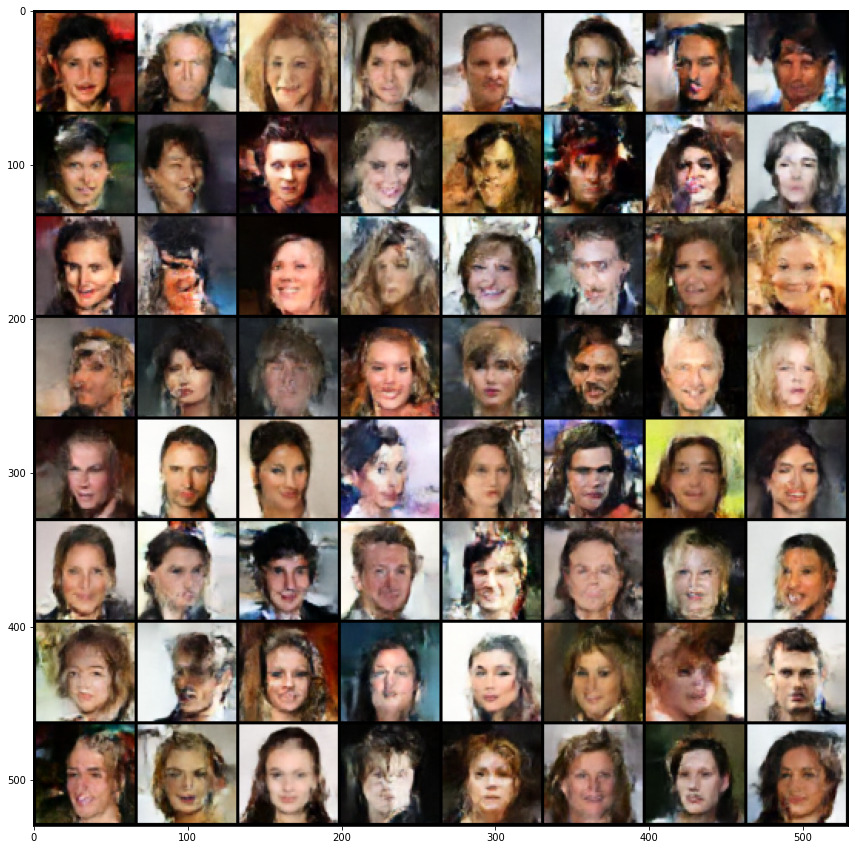

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(torchvision.utils.make_grid(samples).cpu().permute(1,2,0))

FID расчеты:

Посчитаем FID между реальным изображением и его сэмплом норм потоком:

In [ ]:
repr1 = next(iter(dataloader)).view(64, -1).detach().cpu().numpy()
repr2 = samples.view(64, -1).detach().cpu().numpy()

In [ ]:
def calculate_fid(repr1, repr2):
    ### BEGIN SOLUTION
    from scipy import linalg
    if len(repr1.shape) == 3:
        repr1 = repr1.squeeze(1)
    if len(repr2.shape) == 3:
        repr2 = repr2.squeeze(1)    
    mu1 = np.mean(repr1, axis=0)
    mu2 = np.mean(repr2, axis=0)
    sigma1 = np.cov(repr1, rowvar=False)
    sigma2 = np.cov(repr2, rowvar=False)
    cov_root, _ = linalg.sqrtm(np.dot(sigma1, sigma2), disp=False)  
    cov_root = cov_root.real
    part1 = np.dot((mu1-mu2), (mu1-mu2))
    FID = part1 + np.trace(sigma1 + sigma2) - 2 * np.trace(cov_root)
    ### END SOLUTION
    return FID

In [35]:
calculate_fid(repr1[:, :1000], repr2[:, :1000])

17.548675936178796

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA

Здесь нужно обучить VAE до нормального качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=64,
                                         shuffle=True,
                                         drop_last=True)

In [ ]:
next(iter(dataloader)).shape

torch.Size([64, 3, 64, 64])

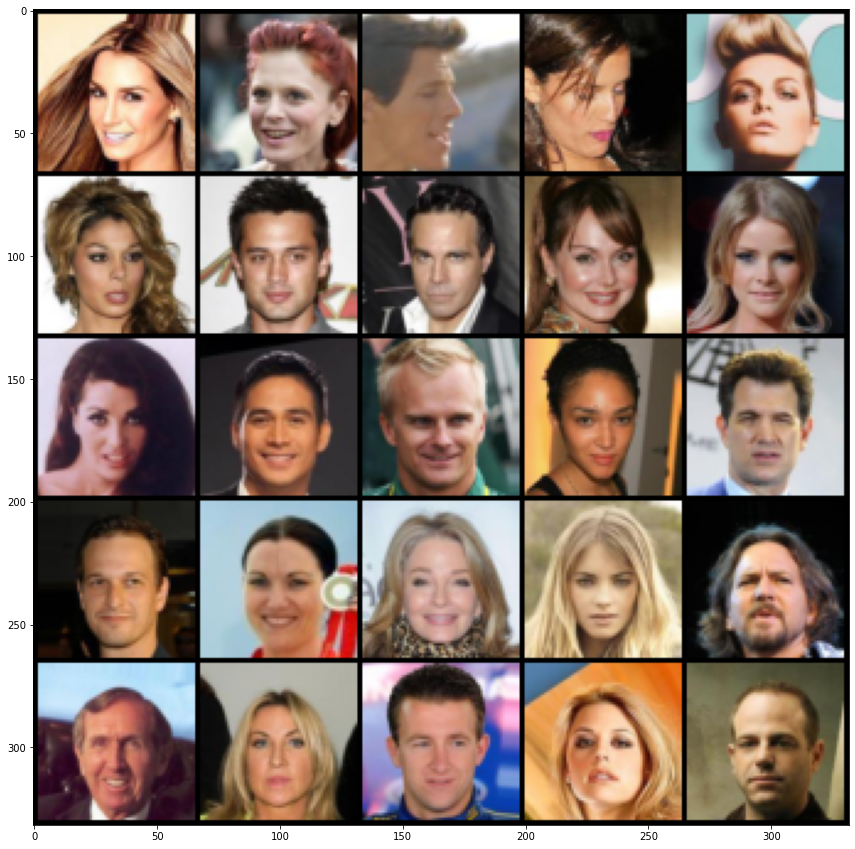

In [ ]:
from torchvision.utils import make_grid
plt.figure(figsize=(15,15))
plt.imshow(make_grid([dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def sample(self, size):
        sample = torch.randn(size, self.nz).to(self.device)
        return model.decode(sample)
    
    @property
    def device(self): return next(self.parameters()).device

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    MSE = F.mse_loss(recon_x.view(batch_size,-1), x.view(batch_size, -1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

log_interval=10
epochs=15


def train(pbar):
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    for batch_idx, data in enumerate(dataloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        loss.backward()
        train_loss += loss.item();
        train_mse += mse_loss.item(); train_kld += kld_loss.item()
        optimizer.step()
        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
with tqdm(total=epochs*len(dataloader), desc=f"[KL: ?] [MSE: ?]") as pbar:
  for epoch in range(1, epochs + 1):
      train(pbar)
      with torch.no_grad():
          sample = model.sample(64).cpu()
          log_img = make_grid(sample)
          path_vae = f'/content/drive/MyDrive/epoch_{epoch}_vae_model.pth'
          torch.save(model.state_dict(), path_vae)

[KL: ?] [MSE: ?]:   0%|          | 0/47475 [00:00<?, ?it/s]

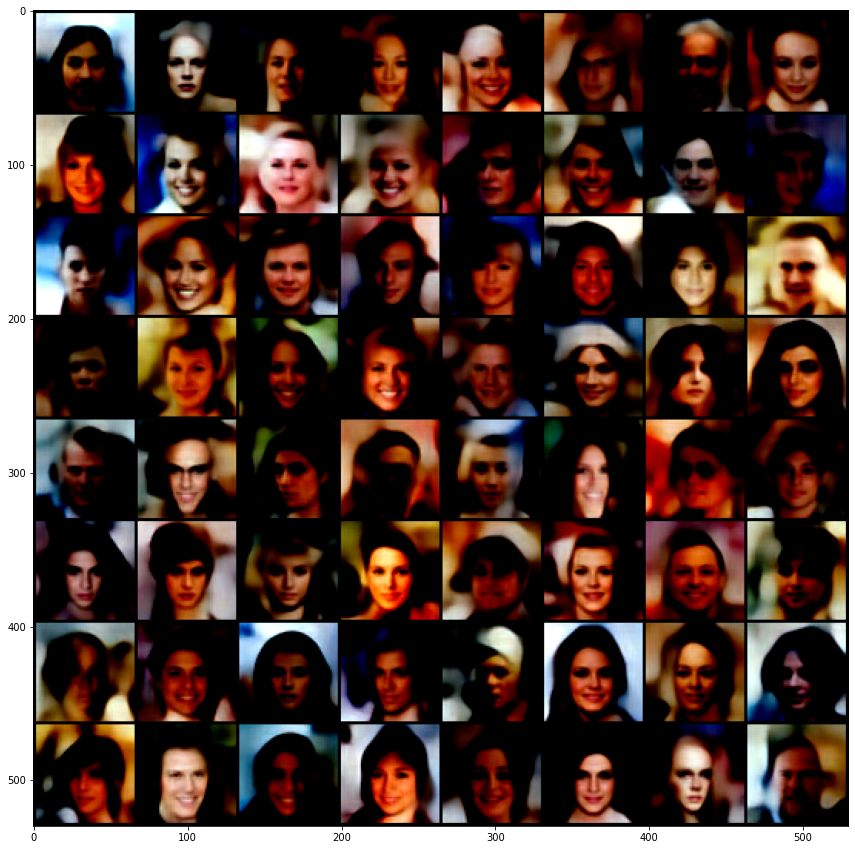

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1,2,0))

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/epoch_15_vae_model.pth'))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    sample = model.sample(64).cpu()
    log_img = make_grid(sample)

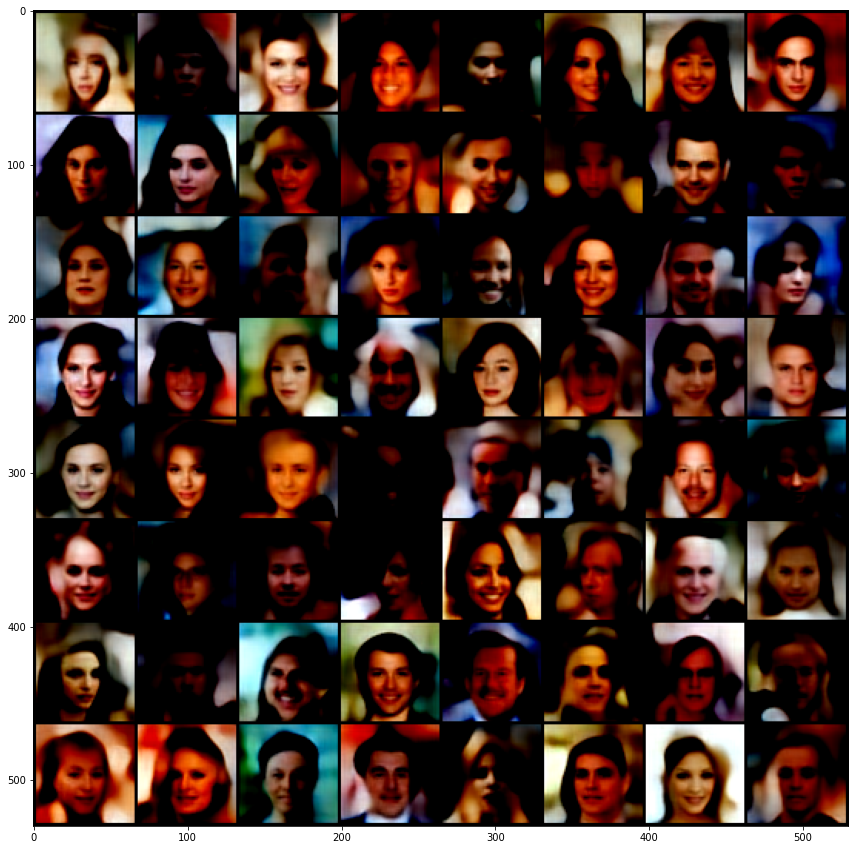

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1,2,0))

FID расчеты:

In [ ]:
def calculate_fid(repr1, repr2):
    ### BEGIN SOLUTION
    from scipy import linalg
    if len(repr1.shape) == 3:
        repr1 = repr1.squeeze(1)
    if len(repr2.shape) == 3:
        repr2 = repr2.squeeze(1)    
    mu1 = np.mean(repr1, axis=0)
    mu2 = np.mean(repr2, axis=0)
    sigma1 = np.cov(repr1, rowvar=False)
    sigma2 = np.cov(repr2, rowvar=False)
    cov_root, _ = linalg.sqrtm(np.dot(sigma1, sigma2), disp=False)  
    cov_root = cov_root.real
    part1 = np.dot((mu1-mu2), (mu1-mu2))
    FID = part1 + np.trace(sigma1 + sigma2) - 2 * np.trace(cov_root)
    ### END SOLUTION
    return FID

In [ ]:
repr1 = model.encode(next(iter(dataloader)).to(device)).detach().cpu().numpy()

In [ ]:
repr2 = model.encode(sample.to(device)).detach().cpu().numpy()

In [ ]:
repr3 = model.encode(model(next(iter(dataloader)).to(device))[0]).detach().cpu().numpy()

Посчитаем FID на реальной картинке и сэмплированной:

In [ ]:
calculate_fid(repr1, repr2)

91.94202695319785

Посчитаем также FID на реальной картинке и сгенерированной, то есть восстановленной от этой же реальной:

In [ ]:
calculate_fid(repr1, repr3)

80.9489511078485

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [ ]:
# YOUR CODE HERE

In [ ]:
class Encoder_vapnev(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder_vapnev, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16). # [batch, 3, 64, 64]
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),                        # [batch, 32, 32, 32] 
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),                     # [batch, 64, 16, 16] 
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),                   # [batch, 128, 8, 8] 
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),                   # [batch, 256, 4, 4] 
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8),

        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

class Decoder_vapnev(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder_vapnev, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        )

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        #output = self.decoder_conv(hidden)
        mean, logvar = output = self.decoder_conv(hidden), self.decoder_conv(hidden)
        latent_y_nvp = self.reparametrize(mean, logvar)
        return latent_y_nvp, mean, logvar

class VAE_vapnev(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=128, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE_vapnev, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = Encoder_vapnev(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder_vapnev(nc=nc, ndf=ndf, nz=nz, isize=isize)

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean_z, logvar_z = self.encoder(x)
        latent_y_nvp, mean_y, logvar_y = self.decoder(latent_z)
        return latent_y_nvp, mean_z, logvar_z, mean_y, logvar_y 
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def sample(self, size):
        sample = torch.randn(size, self.nz).to(self.device)
        return model.decode(sample)
    
    @property
    def device(self): return next(self.parameters()).device

In [ ]:
class RealNVP_for_VAPNEV(nn.Module):
    def __init__(self, datainfo, prior, hps):
        """Initializes a RealNVP.
        Args:
            datainfo: information of dataset to be modeled.
            prior: prior distribution over latent space Z.
            hps: the set of hyperparameters.
        """
        super(RealNVP_for_VAPNEV, self).__init__()
        self.datainfo = datainfo
        self.prior = prior
        self.hps = hps

        chan = datainfo.channel
        size = datainfo.size
        dim = hps.base_dim

        # architecture for ImageNet and CelebA (down to 16 x 16 x C)
        # SCALE 1: 3 x 64 x 64
        self.s1_ckbd = self.checkerboard_combo(chan, dim, size, hps)
        self.s1_chan = self.channelwise_combo(chan*4, dim*2, hps)
        self.order_matrix_1 = self.order_matrix(chan).cuda()
        chan *= 2
        size //= 2
        dim *= 2

        # SCALE 2: 6 x 32 x 32
        self.s2_ckbd = self.checkerboard_combo(chan, dim, size, hps)
        self.s2_chan = self.channelwise_combo(chan*4, dim*2, hps)
        self.order_matrix_2 = self.order_matrix(chan).cuda()
        chan *= 2
        size //= 2
        dim *= 2

        # SCALE 3: 12 x 16 x 16
        self.s5_ckbd = self.checkerboard_combo(chan, dim, size, hps, final=True)

    def checkerboard_combo(self, in_out_dim, mid_dim, size, hps, final=False):
        """Construct a combination of checkerboard coupling layers.
        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            size: height/width of features.
            hps: the set of hyperparameters.
            final: True if at final scale, False otherwise.
        Returns:
            A combination of checkerboard coupling layers.
        """
        if final:
            return nn.ModuleList([
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0., hps)])
        else:
            return nn.ModuleList([
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps), 
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps)])
        
    def channelwise_combo(self, in_out_dim, mid_dim, hps):
        """Construct a combination of channelwise coupling layers.
        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            hps: the set of hyperparameters.
        Returns:
            A combination of channelwise coupling layers.
        """
        return nn.ModuleList([
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps)])

    def squeeze(self, x):
        """Squeezes a C x H x W tensor into a 4C x H/2 x W/2 tensor.
        (See Fig 3 in the real NVP paper.)
        Args:
            x: input tensor (B x C x H x W).
        Returns:
            the squeezed tensor (B x 4C x H/2 x W/2).
        """
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H//2, 2, W//2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C*4, H//2, W//2)
        return x

    def undo_squeeze(self, x):
        """unsqueezes a C x H x W tensor into a C/4 x 2H x 2W tensor.
        (See Fig 3 in the real NVP paper.)
        Args:
            x: input tensor (B x C x H x W).
        Returns:
            the squeezed tensor (B x C/4 x 2H x 2W).
        """
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C//4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C//4, H*2, W*2)
        return x

    def order_matrix(self, channel):
        """Constructs a matrix that defines the ordering of variables
        when downscaling/upscaling is performed.
        Args:
          channel: number of features.
        Returns:
          a kernel for rearrange the variables.
        """
        weights = np.zeros((channel*4, channel, 2, 2))
        ordering = np.array([[[[1., 0.],
                               [0., 0.]]],
                             [[[0., 0.],
                               [0., 1.]]],
                             [[[0., 1.],
                               [0., 0.]]],
                             [[[0., 0.],
                               [1., 0.]]]])
        for i in range(channel):
            s1 = slice(i, i+1)
            s2 = slice(4*i, 4*(i+1))
            weights[s2, s1, :, :] = ordering
        shuffle = np.array([4*i for i in range(channel)]
                         + [4*i+1 for i in range(channel)]
                         + [4*i+2 for i in range(channel)]
                         + [4*i+3 for i in range(channel)])
        weights = weights[shuffle, :, :, :].astype('float32')
        return torch.tensor(weights)

    def factor_out(self, x, order_matrix):
        """Downscales and factors out the bottom half of the tensor.
        (See Fig 4(b) in the real NVP paper.)
        Args:
            x: input tensor (B x C x H x W).
            order_matrix: a kernel that defines the ordering of variables.
        Returns:
            the top half for further transformation (B x 2C x H/2 x W/2)
            and the Gaussianized bottom half (B x 2C x H/2 x W/2).
        """
        x = F.conv2d(x, order_matrix, stride=2, padding=0)
        [_, C, _, _] = list(x.size())
        (on, off) = x.split(C//2, dim=1)
        return on, off

    def restore(self, on, off, order_matrix):
        """Merges variables and restores their ordering.
        (See Fig 4(b) in the real NVP paper.)
        Args:
            on: the active (transformed) variables (B x C x H x W).
            off: the inactive variables (B x C x H x W).
            order_matrix: a kernel that defines the ordering of variables.
        Returns:
            combined variables (B x 2C x H x W).
        """
        x = torch.cat((on, off), dim=1)
        return F.conv_transpose2d(x, order_matrix, stride=2, padding=0)

    def g(self, z):
        """Transformation g: Z -> X (inverse of f).
        Args:
            z: tensor in latent space Z.
        Returns:
            transformed tensor in data space X.
        """
        x, x_off_1 = self.factor_out(z, self.order_matrix_1)
        x, x_off_2 = self.factor_out(x, self.order_matrix_2)

        # SCALE 3: 16 x 16
        for i in reversed(range(len(self.s5_ckbd))):
            x, _ = self.s5_ckbd[i](x, reverse=True)

        x = self.restore(x, x_off_2, self.order_matrix_2)

        # SCALE 2: 32 x 32
        x = self.squeeze(x)
        for i in reversed(range(len(self.s2_chan))):
            x, _ = self.s2_chan[i](x, reverse=True)
        x = self.undo_squeeze(x)

        for i in reversed(range(len(self.s2_ckbd))):
            x, _ = self.s2_ckbd[i](x, reverse=True)

        x = self.restore(x, x_off_1, self.order_matrix_1)

        # SCALE 1: 64 x 64
        x = self.squeeze(x)
        for i in reversed(range(len(self.s1_chan))):
            x, _ = self.s1_chan[i](x, reverse=True)
        x = self.undo_squeeze(x)

        for i in reversed(range(len(self.s1_ckbd))):
            x, _ = self.s1_ckbd[i](x, reverse=True)

        return x

    def f(self, x):
        """Transformation f: X -> Z (inverse of g).
        Args:
            x: tensor in data space X.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        z, log_diag_J = x, torch.zeros_like(x)

        # SCALE 1: 64 x 64
        for i in range(len(self.s1_ckbd)):
            z, inc = self.s1_ckbd[i](z)
            log_diag_J = log_diag_J + inc
        z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)

        for i in range(len(self.s1_chan)):
            z, inc = self.s1_chan[i](z)
            log_diag_J = log_diag_J + inc
        z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

        z, z_off_1 = self.factor_out(z, self.order_matrix_1)
        log_diag_J, log_diag_J_off_1 = self.factor_out(log_diag_J, self.order_matrix_1)

        # SCALE 2: 32 x 32
        for i in range(len(self.s2_ckbd)):
            z, inc = self.s2_ckbd[i](z)
            log_diag_J = log_diag_J + inc
        z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)

        for i in range(len(self.s2_chan)):
            z, inc = self.s2_chan[i](z)
            log_diag_J = log_diag_J + inc
        z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

        z, z_off_2 = self.factor_out(z, self.order_matrix_2)
        log_diag_J, log_diag_J_off_2 = self.factor_out(log_diag_J, self.order_matrix_2)

        # SCALE 3: 16 x 16
        for i in range(len(self.s5_ckbd)):
            z, inc = self.s5_ckbd[i](z)
            log_diag_J = log_diag_J + inc

        z = self.restore(z, z_off_2, self.order_matrix_2)
        log_diag_J = self.restore(log_diag_J, log_diag_J_off_2, self.order_matrix_2)
        
        z = self.restore(z, z_off_1, self.order_matrix_1)
        log_diag_J = self.restore(log_diag_J, log_diag_J_off_1, self.order_matrix_1)

        return z, log_diag_J

    def log_prob(self, x):
        """Computes data log-likelihood.
        (See Eq(2) and Eq(3) in the real NVP paper.)
        Args:
            x: input minibatch.
        Returns:
            log-likelihood of input.
        """
        z, log_diag_J = self.f(x)
        log_det_J = torch.sum(log_diag_J, dim=(1, 2, 3))
        log_prior_prob = torch.sum(self.prior.log_prob(z), dim=(1, 2, 3))
        return log_prior_prob + log_det_J

    def sample(self, size):
        """Generates samples.
        Args:
            size: number of samples to generate.
        Returns:
            samples from the data space X.
        """
        C = self.datainfo.channel
        H = W = self.datainfo.size
        z = self.prior.sample((size, C, H, W))
        return self.g(z)

    def forward(self, x):
        """Forward pass.
        Args:
            x: input minibatch.
        Returns:
            log-likelihood of input and sum of squares of scaling factors.
            (the latter is used in L2 regularization.)
        """
        weight_scale = None
        for name, param in self.named_parameters():
            param_name = name.split('.')[-1]
            if param_name in ['weight_g', 'scale'] and param.requires_grad:
                if weight_scale is None:
                    weight_scale = torch.pow(param, 2).sum()
                else:
                    weight_scale = weight_scale + torch.pow(param, 2).sum()
        return self.log_prob(x), weight_scale

In [ ]:
prior = distributions.Normal(   # isotropic standard normal distribution
    torch.tensor(0.).to(device), torch.tensor(1.).to(device))

flow_VAE = RealNVP_for_VAPNEV(datainfo=data_info, prior=prior, hps=hps).to(device)
model_VAE = VAE_vapnev().to(device)

optimizer = torch.optim.Adam(list(model_VAE.parameters()) + list(flow_VAE.parameters()), lr=1e-3)

In [ ]:
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]
    MSE = F.mse_loss(recon_x.view(batch_size,-1), x.view(batch_size, -1), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE, KLD

In [ ]:
epoch = 0
running_loss = 0.
running_log_p_z = 0.
optimal_log_ll = float('-inf')
early_stop = 0

image_size = data_info.channel * data_info.size**2    # full image dimension

while epoch < max_epoch:
    epoch += 1
    print('Epoch %d:' % epoch)
    flow_VAE.train()
    model_VAE.train()
    loss_kld= 0
    for batch_idx, data in enumerate(train_loader, 1):
        optimizer.zero_grad()
        x = data
        data = data.to(device)
        latent_y_nvp, mean_z, logvar_z, mean_y, logvar_y = model_VAE(data)

        x, log_det = logit_transform(x)
        x = x.to(device)
        log_det = log_det.to(device)

        _, weight_scale = flow_VAE(x)
        y, _ = flow_VAE.f(x)
        y = y.to(device)
        mean_y = mean_y.to(device)
        logvar_y = logvar_y.to(device)

        log_p_f = - 0.5 * torch.log(torch.tensor(np.array([np.array([torch.prod(torch.diag(i)).item() for i in logvar_y[j]]).sum() for j in \
                                                         range((len(logvar_y)))]),
                                                         dtype=torch.float32, requires_grad=True) + 1e-5).to(device) \
                  - 0.5 * torch.log(torch.ones(64) * torch.pi * 2).requires_grad_().to(device) * image_size \
                  - 0.5 * torch.sum(torch.mul(torch.matmul((y - mean_y), (y - mean_y)), (1 / logvar_y)), dim=(1, 2, 3)).to(device)


        _, kld_loss = loss_function(latent_y_nvp, data, mean_z, logvar_z)
        log_p_z = (log_p_f - log_det).mean()

        loss = log_p_z + kld_loss + scale_reg * weight_scale
        loss.backward()
        running_loss += loss.item();
        running_log_p_z += log_p_z.item(); loss_kld += kld_loss.item()
        optimizer.step()

        if batch_idx % 10 == 0:
            bit_per_dim = (log_p_z.item() + np.log(256.) * image_size) \
                / (image_size * np.log(2.))
            print('[%d/%d]\tloss: %.3f\tlog-ll: %.3f\tbits/dim: %.3f' % \
                (batch_idx*batch_size, len(train_loader.dataset), 
                    loss.item(), log_p_z.item(), bit_per_dim))
    
    mean_loss = running_loss / batch_idx
    mean_log_ll = running_log_p_z / batch_idx
    mean_bit_per_dim = (-mean_log_ll + np.log(256.) * image_size) \
          / (image_size * np.log(2.))
    print('===> Average train loss: %.3f' % mean_loss)
    print('===> Average train log-likelihood: %.3f' % mean_log_ll)
    print('===> Average train bit_per_dim: %.3f' % mean_bit_per_dim)
    running_loss = 0.
    running_log_p_z = 0.
    loss_kld= 0

    flow_VAE.eval()
    model_VAE.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader, 1):
            x = data
            data = data.to(device)
            latent_y_nvp, mean_z, logvar_z, mean_y, logvar_y = model_VAE(data)

            x, log_det = logit_transform(x)
            x = x.to(device)
            log_det = log_det.to(device)

            #_, weight_scale = flow_VAE(x)
            y, _ = flow_VAE.f(x)
            y = y.to(device)
            mean_y = mean_y.to(device)
            logvar_y = logvar_y.to(device)

            log_p_f = -0.5 * torch.log(torch.tensor(np.array([np.array([torch.prod(torch.diag(i)).item() for i in logvar_y[j]]).sum() for j in range((len(logvar_y)))]), 
                                                            dtype=torch.float32, requires_grad=True) + 1e-5) \
                      - 0.5 * torch.log(torch.ones(64) * torch.pi * 2).requires_grad_().to(device) * image_size \
                      - 0.5 * torch.sum(torch.mul(torch.matmul((y - mean_y), (y - mean_y)), (1 / logvar_y)), dim=(1, 2, 3))


            _, kld_loss = loss_function(latent_y_nvp, data, mean_z, logvar_z)
            log_p_z = (log_p_f - log_det).mean()

            loss = log_p_z + kld_loss #+ scale_reg * weight_scale

            running_loss += loss.item();
            running_log_p_z += log_p_z.item(); loss_kld += kld_loss.item()


        mean_loss = running_loss / batch_idx
        mean_log_ll = running_log_p_z / batch_idx
        mean_bit_per_dim = (-mean_log_ll + np.log(256.) * image_size) \
            / (image_size * np.log(2.))
        print('===> Average validation loss: %.3f' % mean_loss)
        print('===> Average validation log-likelihood: %.3f' % mean_log_ll)
        print('===> Average validation bits/dim: %.3f' % mean_bit_per_dim)
        running_loss = 0.
        running_log_p_z = 0.
 
        random_images = next(iter(dataloader))
        latent_y_nvp, mean_z, logvar_z, mean_y, logvar_y = model_VAE(random_images)
        samples = flow_VAE.g(latent_y_nvp)
        samples, _ = logit_transform(samples, reverse=True)
        torchvision.utils.save_image(torchvision.utils.make_grid(samples),
            '/content/drive/MyDrive/samples_vapnev/' + filename + '_ep%d.png' % epoch)

    if mean_log_ll > optimal_log_ll: 
        early_stop = 0
        optimal_log_ll = mean_log_ll
        torch.save(flow, '/content/drive/MyDrive/vapnev_models/' + filename + '.model')
        print('[MODEL SAVED]')
    else:
        early_stop += 1
        if early_stop >= 100:
            break
    
    print('--> Early stopping %d/100 (BEST validation log-likelihood: %.3f)' \
        % (early_stop, optimal_log_ll))

print('Training finished at epoch %d.' % epoch)

Epoch 1:
[640/189417]	loss: nan	log-ll: nan	bits/dim: nan
[1280/189417]	loss: nan	log-ll: nan	bits/dim: nan


/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


[1920/189417]	loss: -inf	log-ll: -inf	bits/dim: -inf
[2560/189417]	loss: nan	log-ll: nan	bits/dim: nan
[3200/189417]	loss: nan	log-ll: nan	bits/dim: nan
[3840/189417]	loss: nan	log-ll: nan	bits/dim: nan
[4480/189417]	loss: nan	log-ll: nan	bits/dim: nan
[5120/189417]	loss: nan	log-ll: nan	bits/dim: nan
[5760/189417]	loss: nan	log-ll: nan	bits/dim: nan
[6400/189417]	loss: nan	log-ll: nan	bits/dim: nan
[7040/189417]	loss: nan	log-ll: nan	bits/dim: nan
[7680/189417]	loss: nan	log-ll: nan	bits/dim: nan
[8320/189417]	loss: nan	log-ll: nan	bits/dim: nan
[8960/189417]	loss: nan	log-ll: nan	bits/dim: nan
[9600/189417]	loss: nan	log-ll: nan	bits/dim: nan
[10240/189417]	loss: nan	log-ll: nan	bits/dim: nan
[10880/189417]	loss: nan	log-ll: nan	bits/dim: nan
[11520/189417]	loss: nan	log-ll: nan	bits/dim: nan
[12160/189417]	loss: nan	log-ll: nan	bits/dim: nan
[12800/189417]	loss: nan	log-ll: nan	bits/dim: nan
[13440/189417]	loss: nan	log-ll: nan	bits/dim: nan
[14080/189417]	loss: nan	log-ll: nan	bits

KeyboardInterrupt: ignored

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [ ]:
# YOUR CODE HERE

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.